In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import warnings
import itertools as it
import time
import math
import polytope as pc
import pypoman
import random

import quantpy as qp

from tqdm.notebook import tqdm

warnings.filterwarnings('ignore', category=np.ComplexWarning)

titlesize = 32
labelsize = 44
legendsize = 32
xticksize = 34
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

%matplotlib inline

In [2]:
def plot_renner_intervals(state, n_measurements=1000, POVM='proj-set'):
    tmg = qp.StateTomograph(state)
    tmg.experiment(n_measurements, POVM)

    t0 = time.time()
    dist_coarse, CL_coarse = tmg.wang_interval(1000, 'coarse')
    t1 = time.time()
#     dist_exact, CL_exact = tmg.wang_interval(1000, 'exact')
    t2 = time.time()
    dist_bbox, CL_bbox = tmg.wang_interval(1000, 'bbox')
    t3 = time.time()
    dist_approx, CL_approx = tmg.wang_interval(1000, 'hit_and_run')
    t4 = time.time()

    dist_true = []
    for _ in range(1000):
        tmg.experiment(n_measurements, POVM)
        state_hat = tmg.point_estimate('lin')
        dist_true.append(qp.hs_dst(state_hat, state))
    dist_true = sorted(dist_true)
    CL_true = np.linspace(0, 1, 1000)

    print(f'Coarse: {t1 - t0} s')
    print(f'Exact: {t2 - t1} s')
    print(f'Bbox: {t3 - t2} s')
    print(f'Approx: {t4 - t3} s')
    
    x_max = max([
        dist_approx[np.asarray(CL_approx > 0.99).nonzero()[0][0]],
#         dist_exact[np.asarray(CL_exact > 0.99).nonzero()[0][0]],
        dist_bbox[np.asarray(CL_bbox > 0.99).nonzero()[0][0]],
        dist_true[np.asarray(CL_true > 0.99).nonzero()[0][0]],
    ])
    
    x_min = min([
        dist_approx[np.asarray(CL_approx > -0.5).nonzero()[0][0]],
#         dist_exact[np.asarray(CL_exact > -0.5).nonzero()[0][0]],
        dist_bbox[np.asarray(CL_bbox > -0.5).nonzero()[0][0]],
        dist_true[np.asarray(CL_true > -0.5).nonzero()[0][0]],
    ])

    plt.figure(figsize=(20, 12), dpi=200)
    plt.xlabel('$\\delta$')
    plt.ylabel('$\\epsilon$')
    plt.grid()
    plt.ylim((-0.05, 1.05))
    plt.xlim(left=x_min, right=x_max)
    # plt.plot(dist_coarse, CL_coarse, 'k', label='Coarse', linestyle='--')
#     plt.plot(dist_exact, CL_exact, 'k', label='Exact', linestyle='-')
    plt.plot(dist_bbox, CL_bbox, 'k', label='Bbox', linestyle='-.')
    plt.plot(dist_approx, CL_approx, 'k', label='Hit and run', linestyle=':')
    plt.plot(dist_true, CL_true, 'k', label='True', linestyle='--')
    plt.legend()
    plt.show()


Coarse: 0.2383897304534912 s
Exact: 7.152557373046875e-07 s
Bbox: 203.7087435722351 s
Approx: 202.4381604194641 s


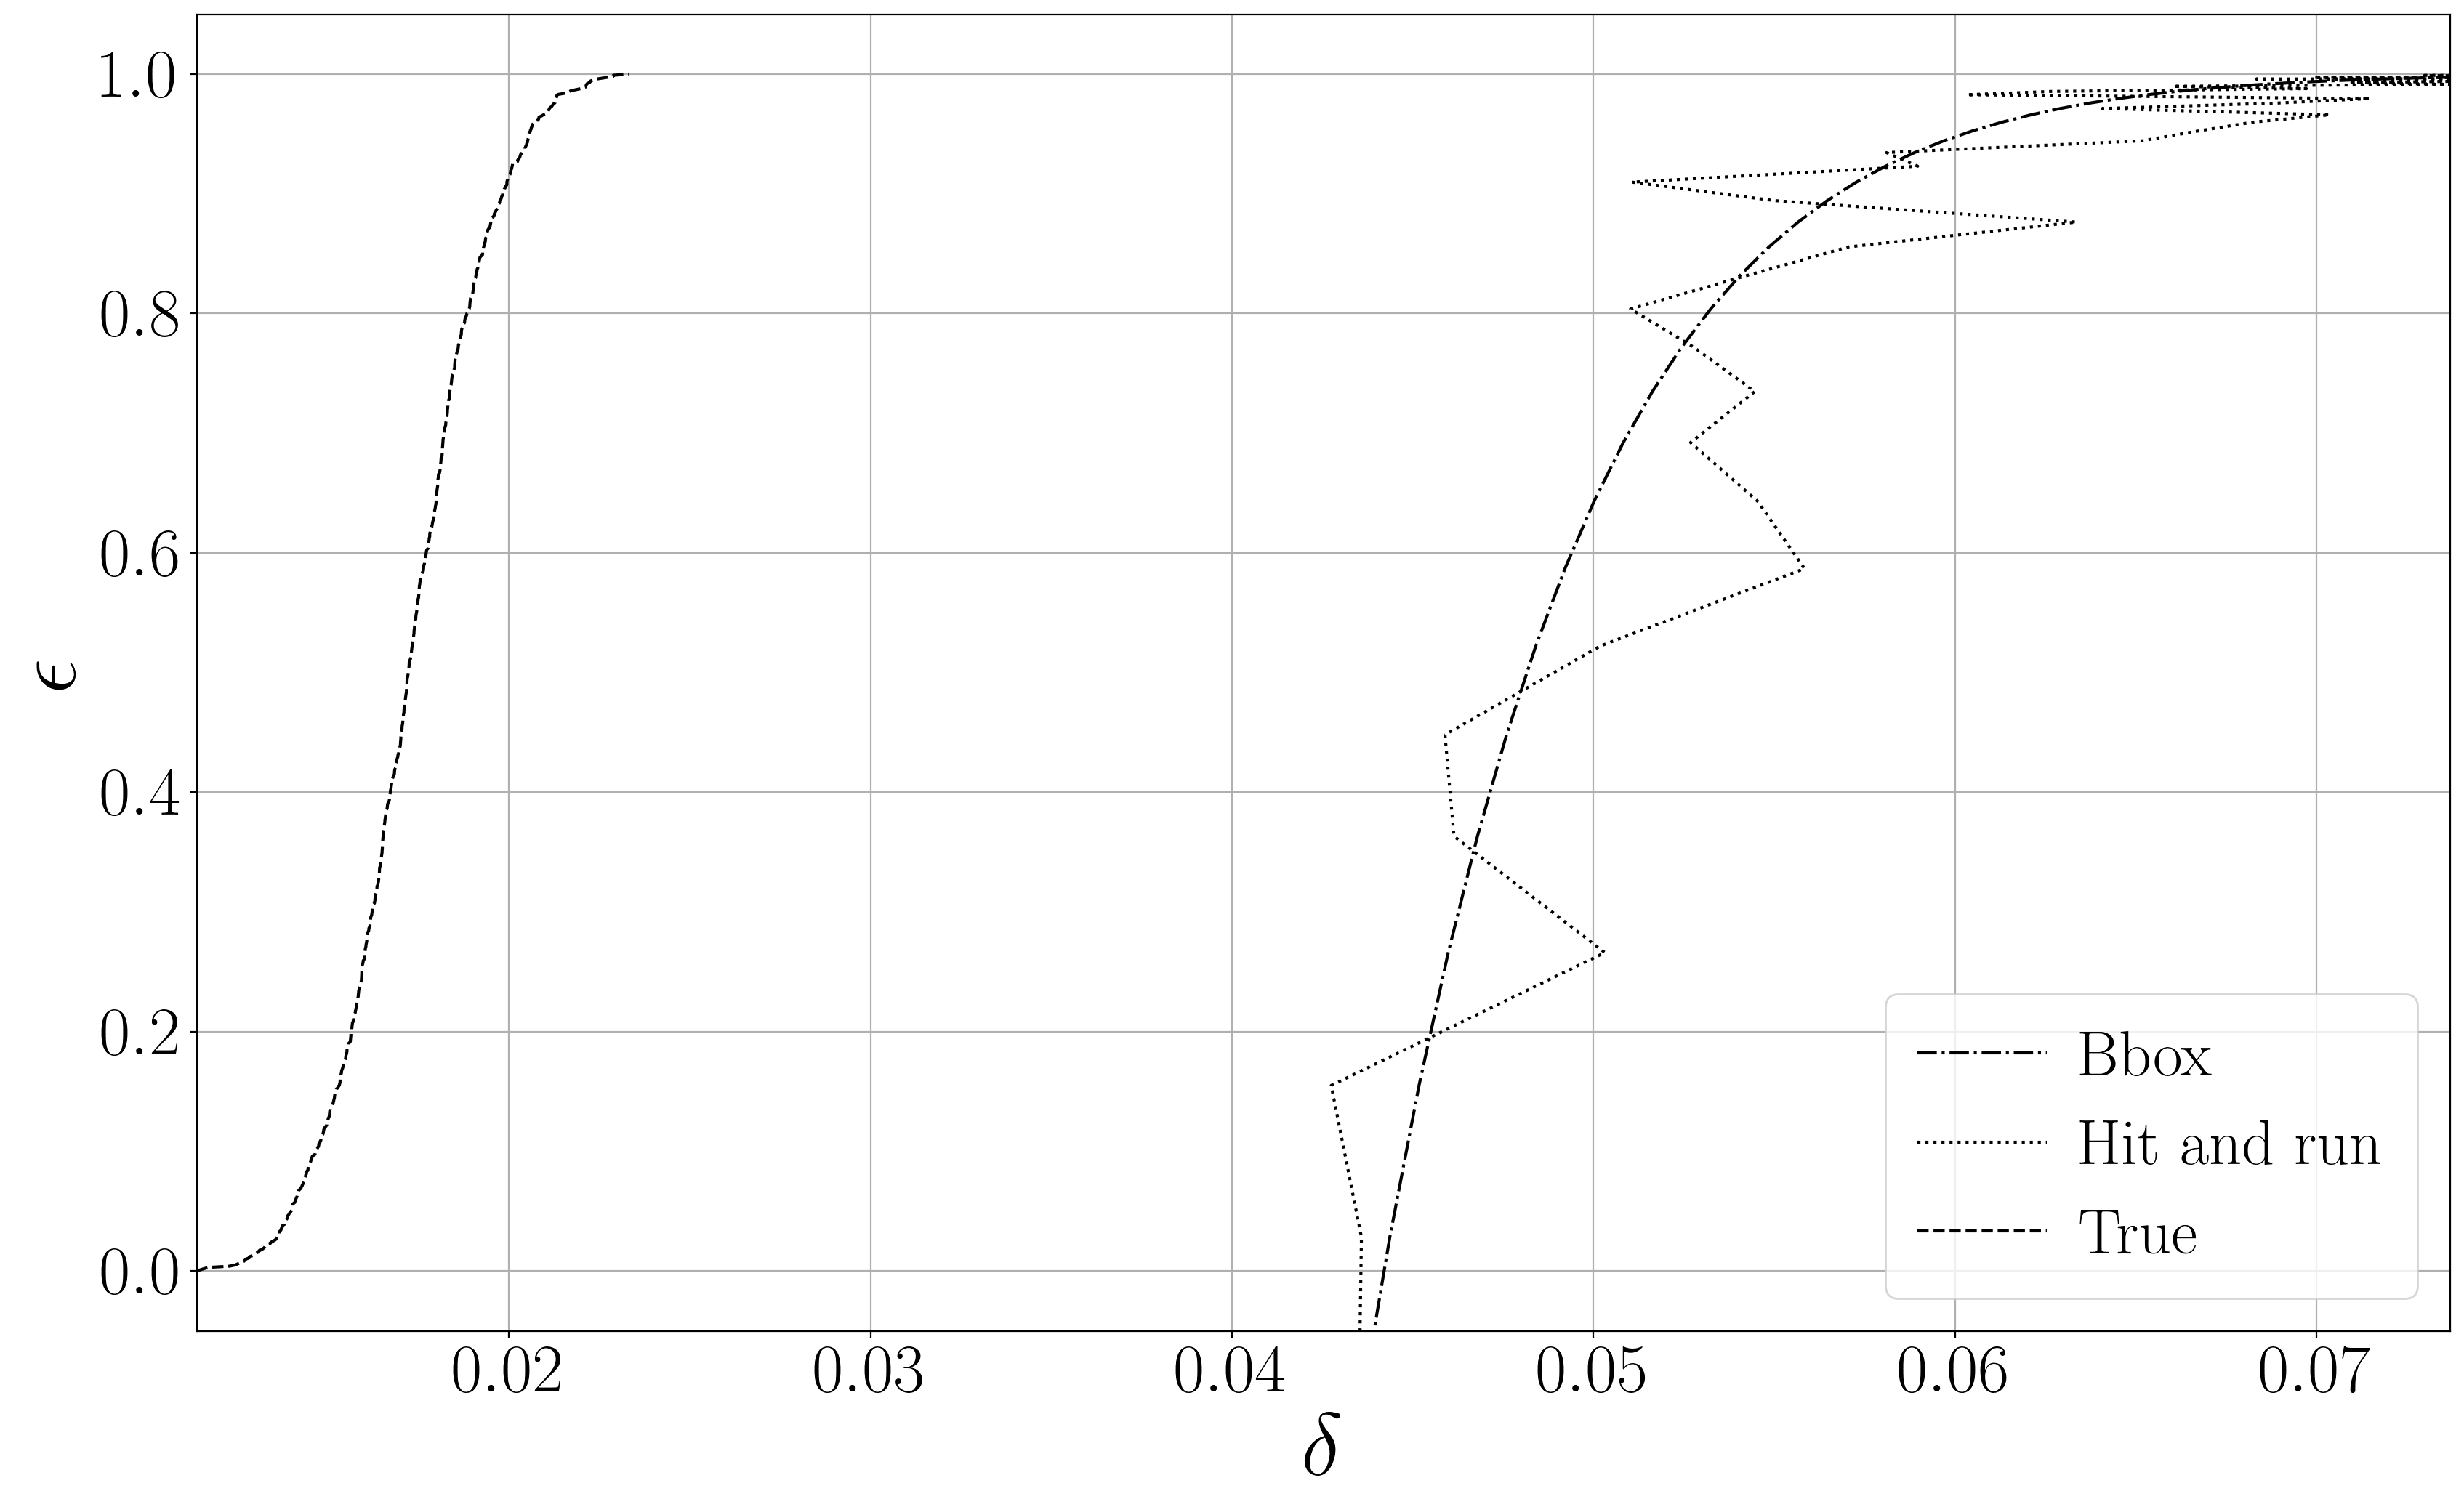

In [5]:
# state = qp.Qobj([1, 0, 0, 0], is_ket=True)
state = qp.qobj.GHZ(3)
plot_renner_intervals(state, 10000, POVM='proj-set')